In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from Bio import Phylo, SeqIO
import numpy as np

import random
from matplotlib import pyplot as plt

from io import StringIO
from collections import defaultdict

import pandas as pd
from scipy.optimize import minimize
from scipy import stats

In [4]:
import weighting_methods

# Reading in and processing test-trees

In [178]:
# tree = Phylo.read('../../Tree_rooting/Data/raw_OMA_trees/OMAGroup_479938.mafft.afa.treefile.Rooted.MPAJH', 'newick')
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick', rooted=True)
# tree = Phylo.read(StringIO('(((A:20, B:20):30,C:50):30, D:0.001)'), 'newick', rooted=True)
# tree = Phylo.read('../../Tree_rooting_analysis/Data/OMA_group_data/eukaryotes/processed_OMA_trees/'
#                   'OMAGroup_479938.treefile.RootedNoZero.MADAJH', 'newick', rooted=True)
tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')




print(len(tree.get_terminals()))
# tree = trim_zero_bls(tree)
# tree.root_at_midpoint()
# print(len(tree.get_terminals()))
# initial_order = tree.get_terminals()
# dicty = {}
# for i,j in enumerate(initial_order):
#     dicty[j.name] = i

1001


In [179]:
tree.is_bifurcating()

True

In [180]:
tree.get_terminals()[:20]

[Clade(branch_length=0.510945638, name='241'),
 Clade(branch_length=0.279960657, name='531'),
 Clade(branch_length=0.000356458, name='238'),
 Clade(branch_length=0.033825018, name='613'),
 Clade(branch_length=0.168821304, name='467'),
 Clade(branch_length=0.055303203, name='264'),
 Clade(branch_length=0.049879201, name='479'),
 Clade(branch_length=0.691409902, name='132'),
 Clade(branch_length=0.276073561, name='443'),
 Clade(branch_length=0.72421479, name='253'),
 Clade(branch_length=0.367150808, name='64'),
 Clade(branch_length=0.140502508, name='287'),
 Clade(branch_length=0.224302988, name='943'),
 Clade(branch_length=0.083495881, name='128'),
 Clade(branch_length=0.031783883, name='314'),
 Clade(branch_length=0.048315449, name='732'),
 Clade(branch_length=0.018019686, name='466'),
 Clade(branch_length=0.451777789, name='25'),
 Clade(branch_length=0.53551816, name='642'),
 Clade(branch_length=0.372964623, name='340')]

In [181]:
if len(tree.get_terminals()) < 100:
    Phylo.draw(tree)

# Using root, get basic variance-covariance method ala Felsenstein

So this is the basic method proposed in Altschull et al (ACL) and it works in my implementation (assuming no zero branch lengths)

In [182]:
tree.root_at_midpoint()
# tree.root_with_outgroup('reference', outgroup_branch_length=0.0)
weights_dict_acl, rooted_tree = weighting_methods.calc_ACL_weights(tree)

In [183]:
weights_dict_acl

{Clade(branch_length=0.91256375, name='210'): 0.0025102636880217186,
 Clade(branch_length=0.018045952, name='569'): 0.0001884660702595697,
 Clade(branch_length=1.501346243, name='765'): 0.0001130333009709891,
 Clade(branch_length=0.018019686, name='466'): 0.0003853233250179974,
 Clade(branch_length=0.578204574, name='478'): 0.0007401244198601823,
 Clade(branch_length=0.140838962, name='93'): 1.0120944882053298e-06,
 Clade(branch_length=0.719207048, name='187'): 0.0005831559883755149,
 Clade(branch_length=0.065267079, name='168'): 5.117895141309263e-06,
 Clade(branch_length=0.656693781, name='942'): 0.00028687414296288237,
 Clade(branch_length=1.038191421, name='798'): 0.0007470781110447142,
 Clade(branch_length=0.014342941, name='3'): 2.5941841832556407e-11,
 Clade(branch_length=1.276951395, name='291'): 0.0009283730134309528,
 Clade(branch_length=0.106739532, name='715'): 0.0006456337906765425,
 Clade(branch_length=0.026486763, name='689'): 0.00047932409619717685,
 Clade(branch_length

In [184]:
np.sum(list(weights_dict_acl.values()))

1.000000017324112

In [185]:
weights_dict_acl[next(tree.find_elements('reference'))]

3.9984249181968064e-05

(array([ 788.,  882.,  927.,  950.,  962.,  971.,  979.,  982.,  985.,
         991.,  995.,  996.,  996.,  997.,  997.,  997.,  997.,  997.,
         997.,  998.,  999.,  999.,  999., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1001.]),
 array([-7.90845675e-11,  1.04721025e-03,  2.09442059e-03,  3.14163092e-03,
         4.18884125e-03,  5.23605159e-03,  6.28326192e-03,  7.33047225e-03,
         8.37768259e-03,  9.42489292e-03,  1.04721

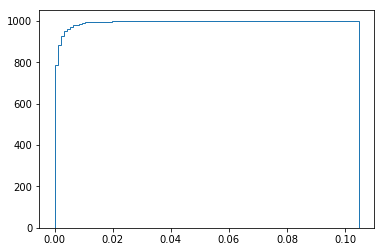

In [188]:
fig, ax = plt.subplots()
ax.hist(list(weights_dict_acl.values()), 100, cumulative=True, histtype='step')

# Stone and Sidow proposed "Branch_Manager" which I at one point implemented and subsequently deleted. Their code works and at the moment I don't see the point.

I, of course, deleted solely because I've gotten a much better grasp on these methods so if I decide to re-write don't want to even deal with the previous monstrosity that surely existed below

# GSC implementation!

There are a few free parameter choices that I haven't fully settled on so as of now GSC methods are really a cluster of related methods all producing slightly different outputs.

Of note, GSC values are highly dependent on the location of the tree root.

TypeError: unorderable types: NoneType() > float()

In [41]:
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick', rooted=True)
tree = Phylo.read(StringIO('(((A:0, B:0):30,C:50):30, D:80)'), 'newick', rooted=True)
# tree = Phylo.read('../../Tree_rooting/Data/euk_trees/KOG0001.faa.aln.nwk.Rooted.MADAJH', 'newick')
# tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/mp_root_trees/1aoeA.newick',\
#                   'newick', rooted=True)



weights_dict = weighting_methods.GSC_adhock(tree)
normed_weights_dict = weighting_methods.normalize_GSC_weights(weights_dict, tree)
print(np.sum([i for i in weights_dict.values()]), tree.total_branch_length())
print(np.sum([i for i in normed_weights_dict.values()]), tree.total_branch_length())

190.0 190.0
2.546875 190.0


In [42]:
weights_dict

{Clade(branch_length=50.0, name='C'): 68.75,
 Clade(branch_length=0.0, name='B'): 20.625,
 Clade(branch_length=80.0, name='D'): 80.0,
 Clade(branch_length=0.0, name='A'): 20.625}

In [ ]:
weights_dict_v2 = weighting_methods.GSC_adhock_modified(tree)
normed_weights_dict_v2 = weighting_methods.normalize_GSC_weights(weights_dict_v2, tree)

print(np.sum([i[-1] for i in weights_dict_v2.values()]), tree.total_branch_length())
print(np.sum([i[-1] for i in normed_weights_dict_v2.values()]), tree.total_branch_length())

In [ ]:
a = [i[-1] for i in weights_dict.values()]
b = [i[-1] for i in normed_weights_dict.values()]
c = [i[-1] for i in weights_dict_v2.values()]
d = [i[-1] for i in normed_weights_dict_v2.values()]
e = [i for i in weights_dict_acl.values()]

a = np.array(a)/np.mean(a)
b = np.array(b)/np.mean(b)
c = np.array(c)/np.mean(c)
d = np.array(d)/np.mean(d)
e = np.array(e)/np.mean(e)

In [ ]:
fig, ax_arr = plt.subplots(ncols=2, nrows=1)
ax_arr[0].hist(a)
ax_arr[0].hist(b)
ax_arr[1].hist(c)
ax_arr[1].hist(d)

In [ ]:
np.std(a), np.std(b), np.std(c), np.std(d), np.std(e)

# Scratch

In [ ]:
for term_a in tree.get_terminals():
    for term_b in tree.get_terminals():
        print(term_a.name, term_b.name, (weights_dict_v2[term_a][-1]*weights_dict_v2[term_b][-1])/\
        (2*np.sqrt(weights_dict_v2[term_a][-1]*weights_dict_v2[term_b][-1])))

# Henikoff weights

In [ ]:
from Bio import SeqIO
from collections import Counter
from scipy import stats

In [ ]:
# records = list(SeqIO.parse('../../Tree_rooting/Data/Tria_et_al_data/'
#                            'eukaryotes/ingroup/aln/KOG0018.faa.aln', 'fasta'))
# tree = Phylo.read('../../Tree_rooting/Data/Tria_et_al_data/'
#                   'eukaryotes/processed_trees/KOG0018.faa.aln.nwk.Rooted.MADAJH', 'newick')

records = list(SeqIO.parse('../../Tree_rooting/Data/OMA_group_data/eukaryotes/aligned_OMA_groups/'
                           'OMAGroup_833097.mafft.afa', 'fasta'))
tree = Phylo.read('../../Tree_rooting/Data/OMA_group_data/eukaryotes/processed_OMA_trees/'
                           'OMAGroup_833097.treefile.Rooted.MADAJH', 'newick')

In [ ]:
print(len(records))
seqs = np.array([list(record.seq) for record in records])
print(seqs.shape)
seqs_T = seqs.T
print(seqs_T.shape)

In [ ]:
# seqs = np.array([list('GYVGS'),
#                  list('GFDGF'),
#                  list('GYDGF'),
#                  list('GYQGG')])
# seqs_T = seqs.T

In [ ]:
weights_T = []
all_weights = []
for i in seqs_T[:]:
    counter_dict = Counter(i)
    del counter_dict['-']
    r = len(counter_dict.keys())
    positions = np.sum(list(counter_dict.values()))
    weights_dict = {}
    for key, val in counter_dict.items():
    ####Adjust (or don't) according to the percentage of gaps in the sequence
        weights_dict[key] = 1./(r*val)
    temp_array = np.zeros(i.shape)
    for key, val in weights_dict.items():
        np.place(temp_array, i==key, [val])
    temp_array = temp_array * (positions/seqs_T.shape[1])
    weights_T.append(temp_array)
weights_T = np.array(weights_T)
all_weights = weights_T.T
all_weights = np.sum(all_weights, axis=1)

In [ ]:
all_weights = all_weights/np.mean(all_weights)
print(np.sum(all_weights))

In [ ]:
# all_weights = np.sum(all_weights, axis=1)

In [ ]:
# all_weights = all_weights_T.T
# all_weights = np.sum(all_weights, axis=1)

In [ ]:
all_weights

In [ ]:
weights_dict = weighting_methods.GSC_adhock(tree)
normed_weights_dict = weighting_methods.normalize_GSC_weights(weights_dict, tree)
# acl_dict, x = weighting_methods.ACL_adhock(tree)

In [ ]:
a = []
b = []
c = []
# d = []
for i, record in enumerate(records):
#     if tree.find_any(record.id) not in acl_dict.keys():
#         continue
    a.append(all_weights[i])
    b.append(weights_dict[tree.find_any(record.id)][-1])
    c.append(normed_weights_dict[tree.find_any(record.id)][-1])
#     d.append(acl_dict[tree.find_any(record.id)])


a = np.array(a)/np.mean(a)
b = np.array(b)/np.mean(b)
c = np.array(c)/np.mean(c)
# d = np.array(d)/np.mean(d)

In [ ]:
fig, ax_arr = plt.subplots(ncols=3, figsize=(16,3))
ax_arr[0].plot(a,b, 'bo')
ax_arr[1].plot(a,c, 'bo')
ax_arr[2].plot(b,c, 'bo')

In [ ]:
print(stats.spearmanr(a,b),'\n',stats.spearmanr(a,c),'\n',stats.spearmanr(b,c))

In [ ]:
# print(stats.spearmanr(a,d),'\n',stats.spearmanr(b,d),'\n',stats.spearmanr(c,d))

In [ ]:
fig, ax_arr = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
ax_arr[0,0].hist(a,normed=True)
ax_arr[0,1].hist(b, normed=True)
ax_arr[1,0].hist(c, normed=True)
ax_arr[1,1].hist(d, normed=True)

# Krogh and Mitchison max-ent

In [ ]:
# records = list(SeqIO.parse('../../Tree_rooting/Data/Tria_et_al_data/'
#                            'eukaryotes/ingroup/aln/KOG0018.faa.aln', 'fasta'))
# tree = Phylo.read('../../Tree_rooting/Data/Tria_et_al_data/'
#                   'eukaryotes/processed_trees/KOG0018.faa.aln.nwk.Rooted.MADAJH', 'newick')

# records = list(SeqIO.parse('../../Tree_rooting/Data/OMA_group_data/eukaryotes/aligned_OMA_groups/'
#                            'OMAGroup_833097.mafft.afa', 'fasta'))
# tree = Phylo.read('../../Tree_rooting/Data/OMA_group_data/eukaryotes/processed_OMA_trees/'
#                            'OMAGroup_833097.treefile.Rooted.MADAJH', 'newick')

records = list(SeqIO.parse('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/'
                           'aln_fasta_max1k/1aoeA.fasta', 'fasta'))
tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/'
                  'mp_root_trees/1aoeA.newick', 'newick')

In [ ]:
print(len(records))
seqs = np.array([list(record.seq) for record in records])
print(seqs.shape)
seqs_T = seqs.T
print(seqs_T.shape)

In [ ]:
initial_shape = seqs_T.shape
flat_seqs = seqs_T.flatten()
order, flat_array = np.unique(flat_seqs, return_inverse=True)
assert order[0] == '-'
print(flat_array.shape)
replaced_seqs_T = flat_array.reshape(initial_shape)
initial_weights = np.full(replaced_seqs_T[0].shape, fill_value=1./replaced_seqs_T[0].shape[0])
print(initial_weights.shape)
print(replaced_seqs_T.shape)

In [ ]:
def total_ent_fxn(weights, seqs):
    bin_counts = np.apply_along_axis(lambda x: np.bincount(x, weights=weights, minlength=22),\
                                     axis=1, arr=seqs)
    all_ents = stats.entropy(bin_counts.T)
    return -1*np.sum(all_ents)

def total_ent_fxn_weighted(weights, seqs):
    bin_counts = np.apply_along_axis(lambda x: np.bincount(x, weights=weights, minlength=22),\
                                     axis=1, arr=seqs)
    trunc_bin_counts = bin_counts[:,1:]
    ungapped_frac = np.sum(trunc_bin_counts, axis=1)/np.sum(bin_counts, axis=1)
    all_ents = stats.entropy(trunc_bin_counts.T)
    scaled_ents = all_ents*ungapped_frac
    return -1*np.sum(scaled_ents)

def total_ent_fxn_sim_ann(weights, seqs):
    scaled_weights = weights/np.sum(weights)
    bin_counts = np.apply_along_axis(lambda x: np.bincount(x, weights=weights, minlength=22),\
                                     axis=1, arr=seqs)
    all_ents = stats.entropy(bin_counts.T)
    return -1*np.sum(all_ents)

In [ ]:
#Says the sum of all variables must be zero
cons = ({'type': 'eq', 'fun': lambda x: 1- np.sum(x)})
options = {'maxiter':500}


#Required to have non negative values
bnds = tuple((10e-16,1) for x in initial_weights)

# res = minimize(total_ent_fxn, initial_weights, args=(replaced_seqs_T),\
#                method='SLSQP', bounds=bnds, constraints=cons, options=options)
res_gap = minimize(total_ent_fxn_weighted, initial_weights, args=(replaced_seqs_T),\
               method='SLSQP', bounds=bnds, constraints=cons, options=options)
# res_sim_ann = basinhopping(total_ent_fxn_sim_ann, initial_weights,\
#                            minimizer_kwargs={"method": "BFGS", "args": replaced_seqs_T,\
#                                             "options": options})

In [ ]:
# res

In [ ]:
res_gap

In [ ]:
fig, ax = plt.subplots()
ax.plot(res.x, res_gap.x, 'bo')
ax.plot([0,0.15], [0,0.15])
fig, ax = plt.subplots()
ax.hist(res.x, 30, alpha=0.5)
ax.hist(res_gap.x, 30, alpha=0.5)

In [ ]:
bin_counts = np.apply_along_axis(lambda x: np.bincount(x, weights=initial_weights, minlength=22),\
                                 axis=1, arr=replaced_seqs_T)
gap_frac = bin_counts[:,0]/np.sum(bin_counts, axis=1)
trunc_bin_counts = bin_counts[:,1:]
i = stats.entropy(trunc_bin_counts.T)

In [ ]:
trunc_bin_counts.shape

In [ ]:
np.sum(trunc_bin_counts.T, axis=0)

In [ ]:
trunc_bin_counts.T[:,0]

In [ ]:
stats.entropy(trunc_bin_counts.T[:,0])

In [ ]:
stats.entropy(np.bincount(replaced_seqs_T[0]))

In [ ]:
np.bincount(replaced_seqs_T[0])

In [ ]:
np.bincount(replaced_seqs_T[0:2])

In [ ]:
testy = np.apply_along_axis(lambda x: np.bincount(x, minlength=22), axis=1, arr=replaced_seqs_T[:])

In [ ]:
replaced_seqs_T.shape

In [ ]:
testy.shape

In [ ]:
%%timeit
blah = np.apply_along_axis(lambda x: stats.entropy(x), axis=1, arr = testy)

In [ ]:
np.sum(blah)

In [ ]:
all_ents = []
for i in testy:
    all_ents.append(stats.entropy(i))
# print(np.sum(all_ents))

In [ ]:
hmm = stats.entropy(testy.T)

In [ ]:
list(hmm) == all_ents

In [ ]:
np.isclose(hmm, all_ents)

In [ ]:
bin_counts = np.apply_along_axis(lambda x: np.bincount(replaced_seqs_T, weights=weights, minlength=22),\
                                     axis=1, arr=seqs)

# Better GSC implementation?
starting from root and working towards tips rather than vice versa?

In [4]:
# tree = Phylo.read('../../Tree_rooting/Data/raw_OMA_trees/OMAGroup_479938.mafft.afa.treefile.Rooted.MPAJH', 'newick')
# tree = Phylo.read('/Users/adamhockenberry/Downloads/BM_Folder/paper_tree.txt', 'newick', rooted=True)
# tree = Phylo.read(StringIO('(((A:20, B:20):30,C:50):30, D:80)'), 'newick', rooted=False)
# tree = Phylo.read('../../Tree_rooting/Data/euk_trees/KOG0001.faa.aln.nwk.Rooted.MADAJH', 'newick')
tree = Phylo.read('../../Phylogenetic_couplings/Data/psicov150_aln_pdb/raw_trees/1a3aA.newick', 'newick')




print(len(tree.get_terminals()))
# tree = trim_zero_bls(tree)
# tree.root_at_midpoint()
# print(len(tree.get_terminals()))
# initial_order = tree.get_terminals()
# dicty = {}
# for i,j in enumerate(initial_order):
#     dicty[j.name] = i

1001


In [5]:
for i,j in enumerate(tree.get_nonterminals()):
    j.name = 'I{}'.format(i)

In [ ]:
tree.get_terminals()

In [ ]:
tree.get_nonterminals()

In [ ]:
def recursive_quick_GSC(node, weights_dicty, finished):
    if len(node.clades) == 2:
        lclade = node.clades[0]
        rclade = node.clades[1]
        if node.branch_length:
            l_tot = lclade.total_branch_length()
            r_tot = rclade.total_branch_length()
            weights_dicty[lclade] += weights_dicty[node]*(l_tot/(l_tot + r_tot))
            weights_dicty[rclade] += weights_dicty[node]*(r_tot/(l_tot + r_tot))
        recursive_quick_GSC(lclade, weights_dicty, finished)
        recursive_quick_GSC(rclade,weights_dicty,finished)
        finished.append(node)
    elif len(node.clades) == 0:
        finished.append(node)
    return

In [ ]:
weights_dicty = {}
for node in tree.get_terminals() + tree.get_nonterminals():
    weights_dicty[node] = node.branch_length
recursive_quick_GSC(tree.root, weights_dicty, [])

In [ ]:
weights_dicty

In [ ]:
weighting_methods.GSC_adhock(tree)

In [ ]:
tree.depths()

In [ ]:
30*(50/120)

In [ ]:
43.75 / (43.75+43.75+62.5)

In [ ]:
62.5 / (43.75+43.75+62.5)

In [ ]:
8.75/30

In [ ]:
12.5/30

In [ ]:
np.concatenate